This script shows how to use the new software in ipython. Advantage to python: loaded events can be kept in memory. They do not have to be reloaded in case the plot has to be changed.

The first step ist to hand over the folder path to the data (eventfolder = < >). As python script one would work with defining a main. The script can be downloaded as python-file after finishing development.

In [1]:
# path to folder containing the inp-file, trace files and antpos.dat 
eventfolder = "../../CoREAS/GP300_test2/"

In [2]:
import sys
from sys import argv
import os
import glob

import time

import numpy as np
from numpy import *

import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 

from astropy.table import Table
from astropy.table import hstack
import h5py

In [3]:
### Set up LOGGING
import logging
logging.basicConfig(filename="example_usingclass.log", level=logging.INFO)
logger = logging.getLogger('Main')

In [4]:
#### LOADING radio-simus packages
from os.path import split, join, realpath
root_dir = realpath(join(os.path.abspath(''), "..")) # = $PROJECT
sys.path.append(join("/home/laval1NS/zilles/radio-simus/", "lib", "python"))
#import radio_simus 
from radio_simus.signal_treatment import p2p
from radio_simus.shower import *
from radio_simus.detector import detector, create_from_file, get_array, get_slopes, find_antennaposition, find_antennaslope
from radio_simus.__init__ import arrayfile 

..... Loading CONFIG FILE .....: /home/laval1NS/zilles/radio-simus/examples/test.config
..... Loading CONFIG FILE .....: /home/laval1NS/zilles/radio-simus/examples/test.config


In [5]:
'''
##############################
### Preparing python3 script 
###       MAIN   
##############################

if __name__ == '__main__':
    
    if ( len(sys.argv)<2 ):
        print("""
        Example on how to use classes
        -- Analysis trigger for events, create a list of events (class objects) and  trigger 1/0 to class attributes
        -- create a png with statistic for triggering
        
        Use: python3 example_usingclass.py <folder event set>
        Example: python3 example_usingclass.py ../../CoREAS/GP300_centered/
        
        NOTE: still ongoing work, already usable
        
        ATTENTION:
        -- adapt the paths given in the config-file so that eg the antenna reponse can be read-in correctly
        """)
        sys.exit(0)



    # path to folder containing the inp-file, trace files and antpos.dat 
    eventfolder = sys.argv[1]
    
    #### from here on -> indent
'''    

'\n##############################\n### Preparing python3 script \n###       MAIN   \n##############################\n\nif __name__ == \'__main__\':\n    \n    if ( len(sys.argv)<2 ):\n        print("""\n        Example on how to use classes\n        -- Analysis trigger for events, create a list of events (class objects) and  trigger 1/0 to class attributes\n        -- create a png with statistic for triggering\n        \n        Use: python3 example_usingclass.py <folder event set>\n        Example: python3 example_usingclass.py ../../CoREAS/GP300_centered/\n        \n        NOTE: still ongoing work, already usable\n        \n        ATTENTION:\n        -- adapt the paths given in the config-file so that eg the antenna reponse can be read-in correctly\n        """)\n        sys.exit(0)\n\n\n\n    # path to folder containing the inp-file, trace files and antpos.dat \n    eventfolder = sys.argv[1]\n    \n    #### from here on -> indent\n'

In [6]:
### SETTING UP THE ANTENNA ARRAY

#create  "empty detector"
det = detector()
#create detector=antenna array from file defined in config file
create_from_file(det, arrayfile)

In [12]:
### EVENT list
print("\nScan of events ...")

event = [] # python list
# loop over all folder
for path in tqdm.tqdm(glob.glob(eventfolder+"/*/")):
    if os.path.isdir(path): # only pick event folders
        logger.debug("... Reading Event from:"+ path)

            
        # loop over all antenna positions in event
        i=0
        trigger_any=[]
        trigger_xy=[]
                

        for file in glob.glob(path+"/*.hdf5"):
            ## find antenna position and its slope per ID - works
            ID = int(file.split('/')[-1].split('.hdf5')[0].split('table_')[-1])
            #pos_ant = find_antennaposition(det, ID)
            #pos_slope = find_antennaslope(det, ID)
                
            if i==0: # just get the first antenna to readin meta info            
                #### EFIELD just as example how to read in
                f = Table.read(file, path='efield') 
                #print("\n simulated position ", f.meta["position"])
                    
                # create shower object and set attributes
                testshower = SimulatedShower()
                loadInfo_toShower(testshower, f.meta)

                logger.info("   SUMMARY EVENT: ShowerID = "+  str(testshower.showerID)
                            + " primary = "+ str(testshower.primary)+ " energy/eV = "+ str(testshower.energy) 
                            + " zenith/deg = "+ str(testshower.zenith)+ " azimuth/deg = "
                            + str(testshower.azimuth)+ " injectionheight/m = "+ str(testshower.injectionheight) )
                        
                event.append(testshower)
            i+=1
                    
                    
            #### VOLTAGES - add trigger info to shower object
            try:
                g = Table.read(file, path='voltages') 
                    
                # info: trigger = [thr_aggr, any_aggr, xz_aggr, thr_cons, any_cons, xy_cons]
                # Here: only ask for aggressive value for triggering
                if g.meta["trigger"][1] ==1:
                    trigger_any.append(ID)
                if g.meta["trigger"][2] ==1:
                    trigger_xy.append(ID)
            except IOError:
                logger.error("Voltages not computed for antenna: "+ str(ID) +" in "+path)

                
        ## EXAMPLE: Trigger Analysis
        if len(trigger_any)>5 or len(trigger_xy)>5:
            logger.info("   => shower triggers (aggr): any =" + str(len(trigger_any)) + " xy = " + str(len(trigger_xy)))
            # add trigger info to class
            event[-1].trigger=1
        else:
            event[-1].trigger=0
                  
    else: 
        continue

  0%|          | 0/4 [00:00<?, ?it/s]


Scan of events ...


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


In [13]:
###### START ANALYSIS ################### 
print("\nStart an analysis ...")    

# print attributes - define by object class, does not mean that they are !=None
print("\nAvailable attributes: ", testshower._attributes ) # refers to last event

Event_ID=list(map(lambda i: i.showerID, event))

### Calculate Ratio of detected events
trigger=list(map(lambda i: i.trigger, event))
print("\n"+str(sum(trigger))+" out of "+str(len(trigger))+
      " events detected --> "+str(100.* sum(trigger)/len(trigger))+"% detection rate"+"\n")    

### find triggered events
trigger=np.asarray(trigger)
index = np.where(trigger==1)[0]

# parameters
energy=np.asarray(list(map(lambda i: i.energy/u.eV, event)))
zenith=np.asarray(list(map(lambda i: i.zenith/u.deg, event)))
azimuth=np.asarray(list(map(lambda i: i.azimuth/u.deg, event)))
primary=np.asarray(list(map(lambda i: i.primary, event)))



Start an analysis ...

Available attributes:  ('showerID', 'primary', 'energy', 'zenith', 'azimuth', 'injectionheight', 'trigger', 'simulation', 'Xmax')

4 out of 4 events detected --> 100.0% detection rate



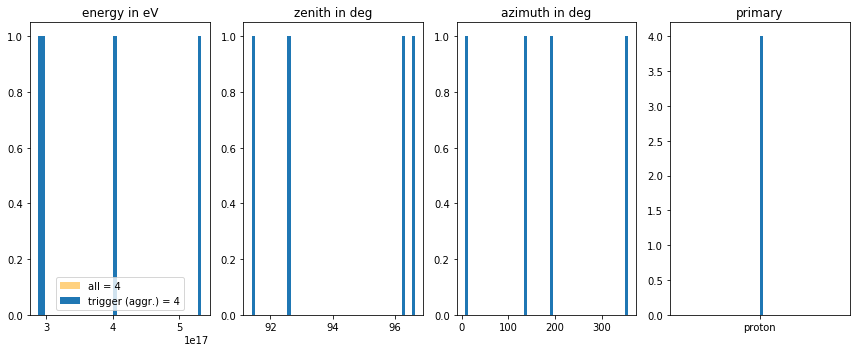

In [14]:
# Plot
plt.rcParams.update({'figure.figsize':(12,5)})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.hist(energy, color="orange", bins=50, alpha=0.5, label='all = '+str(len(trigger)))
ax1.hist(energy[index], bins=50, label='trigger (aggr.) = '+str(sum(trigger)))
ax1.legend()
ax1.set_title('energy in eV')

ax2.hist(zenith, color="orange", bins=50, alpha=0.5)
ax2.hist(zenith[index], bins=50)
ax2.set_title('zenith in deg')

ax3.hist(azimuth, color="orange", bins=50, alpha=0.5)
ax3.hist(azimuth[index], bins=50)
ax3.set_title('azimuth in deg')

ax4.hist(primary, color="orange", bins=50, alpha=0.5)
ax4.hist(primary[index], bins=50)
ax4.set_title('primary')

fig.tight_layout()
plt.show()   

In [15]:
plt.savefig(eventfolder+"/trigger_stats.png")
print("PNG saved:" + eventfolder+"/trigger_stats.png")
logger.info("PNG saved:" + eventfolder+"/trigger_stats.png")

PNG saved:../../CoREAS/GP300_test2//trigger_stats.png


<Figure size 864x360 with 0 Axes>

In [16]:
#====== end of run =======      
logger.info("Done within "+str(time.clock()) +"s")    